<a href="https://colab.research.google.com/github/Bigdata-webtoon-recommendation/webtoon-recommend/blob/main/Copy_of_webtoon_recommend_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install konlpy

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from konlpy.tag import Komoran
from konlpy.tag import Kkma
from re import match
from gensim.models.word2vec import Word2Vec


## **[INPUT(나이 / 좋아하는 웹툰)]**
## 옵션 1: q를 입력받을 때까지 계속 받음, 3개 이상

+ 19세 이하일 경우 성인용 웹툰 data에서 삭제
+ 평점 상위 10% 에는 가중치 높게, 하위 10% 에는 가중치 낮게, 나머지는 동일

In [3]:
# 전체 네이버 + 다음 웹툰 갯수 2383개 // 네이버 1- 1181, 다음 1182 - 2383
data = pd.read_csv("./naver_daum_integration_v3.csv")
#data.last_valid_index

# 추천 점수 저장할 리스트 선언 (data의 idx(1~2383)을 인덱스로)
recommend_score = [0 for i in range(len(data)+1)]

# 나이 입력받기
age = input('나이를 입력하세요: ')

# 잘못 입력했을 경우 정확히 입력할 때까지 반복
while not age.isdigit():
    age = input('정확한 나이를 입력하세요: ')
    if age.isdigit():
        break
    
# 전체 웹툰 제목 받아오기 (input 값 비교용)
title = np.array(data['name'].tolist())
keywords = np.array(data['keywords'].tolist())

# 입력한 웹툰의 제목을 저장하는 리스트
input_list = []

# q를 입력할 때까지 좋아하는 웹툰 제목을 입력받음, 무조건 세 개 이상 입력해야함, 중복 입력 불가능
while 1:
    a = input('좋아하는 웹툰을 입력하세요(q 입력 시 종료): ')
    if a == 'q':
        if len(input_list) >= 3:
            break
        else:
            print("웹툰을 세 개 이상 입력하세요")
    elif a not in title:
        print('입력한 웹툰이 존재하지 않습니다.')
    elif a in input_list:
        print('중복된 웹툰입니다.')
    else:
        input_list.append(a)

# like_list에 입력받은 웹툰 정보를 저장, 각 요소는 Series type으로 되어있음
like_list = []
for i in input_list:
    like_list.append(data[data.name == i])

# like_list에 저장된 각 요소를 하나의 DataFrame으로 합쳐줌 -> like_df에는 입력받은 웹툰들이 DataFrame의 행 형태로 있음
like_df = like_list[0]
for i in like_list[1:]:
    like_df = pd.concat([like_df, i])

# 입력받은 나이가 19세 미만이면 19세 웹툰은 data(추천 데이터셋)에서 삭제
if int(age) < 19:
    data = data[data.age_limit != 1]
    

############ score 가중치 계산 ############

# score의 내림차순으로 정렬한 data를 score_arrange_data에 저장
score_arrange_data = data.sort_values(by=['score'], axis=0, ascending=False)

# data 개수의 10%는 238개
ten_percent = round(len(data) * 0.1)

# 상위 10%의 가장 낮은 점수(9.96)과 하위 10%의 가장 높은 점수(8.96)를 저장 (동점인 항목까지 가중치 부여에 포함하기 위함)
high_score = score_arrange_data.iloc[ten_percent - 1].score
low_score = score_arrange_data.iloc[len(data)-ten_percent].score

# score가 높은 idx(291개), score가 낮은 idx(238개)를 배열에 각각 저장
high_score_list = data[data['score'] >= high_score].idx.values
low_score_list = data[data['score'] <= low_score].idx.values

# score가 높은 웹툰과 낮은 웹툰에 해당하는 idx의 recommend score 점수에 가중치 부여 (각각 1과 -1)
for i in high_score_list:
    recommend_score[i] += 1
    
for i in low_score_list:
    recommend_score[i] -= 1

나이를 입력하세요: 24
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 싸움의 기술2
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 간 떨어지는 동거
좋아하는 웹툰을 입력하세요(q 입력 시 종료): 주간소년열애사
좋아하는 웹툰을 입력하세요(q 입력 시 종료): q


In [4]:
like_df_genre = like_df[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]
like_df_keywords = like_df[['keywords']]


In [22]:
len(input_list)

str = like_df_keywords.keywords.values[0][1:-1]
str = str.replace("'","")
print(str)
input_words = str.split(', ')
print(input_words)

고교생, 진정, 왕따, 전설, 전설적, 싸움, 싸움꾼, 전교
['고교생', '진정', '왕따', '전설', '전설적', '싸움', '싸움꾼', '전교']


In [39]:
like_df_keywords.head()

,keywords
1515,"['고교생', '진정', '왕따', '전설', '전설적', '싸움', '싸움꾼', ..."
295,"['동거', '구미호', '여우', '노력', '여대', '불의', '제안', '사..."
1289,"['고등학생', '드라마', '치정', '금요일', '열애']"


In [43]:
  str = like_df_keywords.keywords.values[2][1:-1].replace("'","")
  print(str)
  print(len(input_list))

고등학생, 드라마, 치정, 금요일, 열애
3


In [45]:
input_words = []

for i in range (0, len(input_list)):
  str = like_df_keywords.keywords.values[i][1:-1].replace("'","")
  input_words.append(str.split(', '))

print(input_words[0])
print(input_words[1])
print(input_words[2])

['고교생', '진정', '왕따', '전설', '전설적', '싸움', '싸움꾼', '전교']
['동거', '구미호', '여우', '노력', '여대', '불의', '제안', '사고', '여대생', '구슬', '해결', '사태', '어르신']
['고등학생', '드라마', '치정', '금요일', '열애']


# **[ 추천 알고리즘 구현 정리 ]**

* Content-based 에서 사용하는 features

  * 제목/작가/ **평점** / 연령정보 / **장르** / **키워드**
    * 작가는 추후 고려요소! (or 작가는 너무 같은작가가 별로 없는 편이니까 마지막에 top30정도 추리고 나서 가중치 둬서 올리는 식으로)

* 결론적으로 content-based에서 최종score에 반영되는것은
    * **평점(rating_score)**
    * **장르(genre_score)**
    * **키워드(story_score)**
    * **(recommend_score) = rating_score * w1 + genre_score * w2 + story_score * w3**

* (recommend_score)을 naver_daum_integration_v2.csv의 각 행, 즉 각 웹툰에 대해 모두 계산해 두어야 함

* (recommend_score) 계산한거 sorting 해서 top30 뽑은 후 적당히 작가 같은거 있으면 점수 올려주는 식으로..


## **평점별 점수 (rating_score) 계산**

[0.5 0.5 1.  ... 0.5 0.5 0.5]


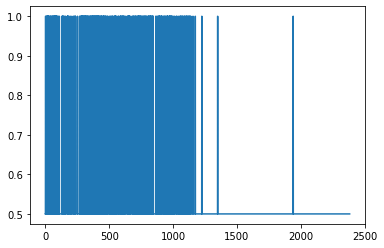

In [23]:
rating_score = np.zeros([len(data)])

# score가 높은 웹툰과 낮은 웹툰에 해당하는 idx의 recommend score 점수에 가중치 부여 (각각 1과 0)
for i in high_score_list:
    rating_score[i] += 1
    
for i in low_score_list:
    rating_score[i] = 0

for i in range (0, 2383):
  if rating_score[i] != (0 or 1):
    rating_score[i] = 0.5

print(rating_score)
plt.plot(rating_score)
plt.show()

## **장르별 유사도 점수 (genre_score) 계산**

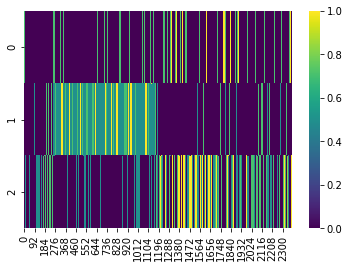

(3, 2383)

In [24]:
# 현재 모든 웹툰 데이터(naver_daum_integration_v2.csv 읽어온 데이터) 는 data라는 dataframe에 저장되어 있음
# g1, ... , g12 를 뽑아서 -> cos sim 비교
data_genre = data
data_genre = data_genre[['g1','g2','g3','g4','g5','g6','g7','g8','g9','g10','g11']]

cosine_sim_val = cosine_similarity(like_df_genre,data_genre)

sns.heatmap(cosine_sim_val, cmap='viridis')
plt.show()

cosine_sim_val.shape


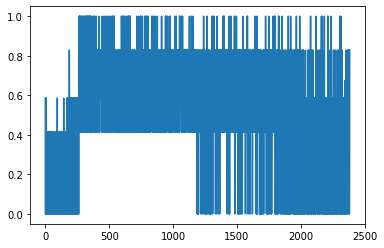

In [25]:
# 사용자가 선호하는 웹툰(n개)에 대해 각각 2380?개의 총 웹툰과의 유사도가 나온 상태.
# 즉 cosin_sim_val의 shape 는 (n, 2383)
# 웹툰 2380개에 대해 각각의 genre_score을 이 n개에서 각각 나온 score을 더해서 평균내고
# 마지막으로 normalize하여 점수 저장

cosine_sim_avg = np.zeros([len(data)])
for i in range (0, len(like_df)):
  cosine_sim_avg = cosine_sim_avg + cosine_sim_val[i]

c_max = cosine_sim_avg.max()
c_min = cosine_sim_avg.min()

cosine_sim_avg_norm = (cosine_sim_avg - c_min) / (c_max - c_min)

plt.plot(cosine_sim_avg_norm)
plt.show()

genre_score = cosine_sim_avg_norm

## **키워드 점수 (story_score) 계산**

In [26]:
#naver_data = pd.read_csv("./crawling_result_naver.csv", names=['제목','작가','평점','장르','연령','한줄 스토리'])
#daum_data = pd.read_csv("./crawling_result_daum.csv")
integration_data = pd.read_csv("./naver_daum_integration_v3.csv")
integration_keywords = integration_data[['keywords']]

#naver_story = naver_data[['한줄 스토리']]
#daum_story = daum_data[['한줄 스토리']]



In [27]:
def keywords_from_story(story):
    komoran = Komoran()
    kkma = Kkma()
    
    keywords = []
    temp = []
    empty_list = [' ']
    
    # kkma와 komoran 두클래스에서 모두 일반명사이고, 길이가 2이상인 단어들
    for i in story.index:
        try:
            val = story._get_value(i,"한줄 스토리")
            words = komoran.pos(val)
            for(text, tclass) in words:
                if tclass=='NNG' and not len(text)==1 and not(match('^[0-9]',text)):
                    temp.append(text)
            words = kkma.pos(val)
            for(text, tclass) in words:
                if tclass=='NNG' and not len(text)==1 and not(match('^[0-9]',text)):
                    temp.append(text)
            keywords.append(temp.copy())
            temp.clear()
            if (i%10)==0:
                print(i,' ', end='')
        except:
            keywords.append(empty_list.copy())
    
    #중복제거
    newkeywords = []
    for i in range(len(keywords)):
        newkeywords.append(list(set(keywords[i])))
        
    # 삭제할 특정 단어 리스트
    delete_words = ['이의', '작품', '만화','남자','여자', '자신', '스스로', 
                '의의' ,'사이','남성','여성','만이','작가', '인간', '사람', 
                '시작', '신작', '이번','과의','순간','이야기','내가', '지금',
                '다운','기고','보늬']
    for i in range(len(newkeywords)):
        for v in newkeywords[i]:
            if v in delete_words:
                newkeywords[i].remove(v)
                
    for i in range(len(newkeywords)):
        for v in newkeywords[i]:
            if v in delete_words:
                newkeywords[i].remove(v)
                
    return newkeywords

In [43]:
# integration_keywords = []
# for keywords in keywords_from_story(naver_story):
#     integration_keywords.append(keywords)
# for keywords in keywords_from_story(daum_story):
#     integration_keywords.append(keywords)

10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890  900  910  920  930  940  950  960  970  980  990  1000  1010  1020  1030  1040  1050  1060  1070  1080  1090  1100  1110  1120  1130  1140  1150  1160  1170  1180  0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  8

In [53]:
keywords_list = integration_keywords.values.tolist()
print(keywords_list[0])
print(len(keywords_list))


["['인생', '한번', '학교']"]
2383


In [58]:
training_keywords = []
temp =[]
for i in range(len(keywords_list)):
    temp_genre = ''.join(keywords_list[i])
    temp_genre = temp_genre.replace("'","")
    temp_genre = temp_genre.replace("[","")
    temp_genre = temp_genre.replace("]","")
    temp_genre = temp_genre.replace(" ","")
    for word in temp_genre.split(','):
        temp.append(word)
    training_keywords.append(temp.copy())
    temp.clear()

In [59]:
keywords_model = Word2Vec(training_keywords, sg=1,window=4, min_count=1,iter=50)
keywords_model.init_sims(replace=True)

In [60]:
print(list(keywords_model.wv.vocab.keys()))

['인생', '한번', '학교', '혼자', '처음', '내성적', '비밀', '내성', '소신', '성향', '취향', '실천', '한림', '세상', '진정', '체육관', '영하', '액션물', '무도', '학원', '그릇', '머릿속', '유미', '생각', '세포', '불명', '아이', '신묘', '정체불명', '부부', '일상', '메신저', '활약', '조조', '개인', '삼국지', '난세', '소통', '방송', '영웅', '군사', '모집', '핸드폰', '선천', '백사', '도구', '이름', '이용', '심리', '소년', '선천적', '두뇌', '운명', '하루', '다정', '천재', '은정', '소녀', '언니', '능력', '지옥', '최강', '복수', '가슴', '대표작', '치사율', '희귀', '두려움', '사랑', '최강자', '대로', '항문', '앞길', '엄마', '기반', '난방', '아빠', '박사', '모제', '임신', '육아', '논문', '중구난방', '발모제', '최고', '우여곡절', '의사', '좌충우돌', '완벽', '출산', '산부인과', '공학', '동안', '이상형', '오늘', '노력', '이상', '얼굴', '뮤즈', '메이크업', '아티스트', '대학생', '집단', '삼국', '엘리트', '마음', '시대', '가야', '전학생', '군대', '충성', '내기', '패배', '여주', '승자', '청순', '외모', '리얼', '커플', '터프', '서울', '메리', '동갑', '감성', '부산', '연애', '가이', '일기', '가의', '기안', '청춘', '멍멍이', '제임스', '세계', '에피소드', '코믹', '막장', '고양', '할머니', '호랑이', '호통', '살해', '행방', '배후', '살인범', '심부름', '생존', '약간', '오의', '일대기', '구주', '정체', '신경', '호가', '모습', '홍시', '단내', '전학', '순정', '주인공'

In [50]:
print(input_words[1][0])
print(input_words[1])


동거
['동거', '구미호', '여우', '노력', '여대', '불의', '제안', '사고', '여대생', '구슬', '해결', '사태', '어르신']


In [98]:
similarity_scores_for_all =[]

for k in range (0, len(input_list)):
  input_keywords = input_words[k] #integration_keywords[0]
  print(input_keywords)

  #keywords_model.wv.similarity('로맨스','성당')
  #compare_keywords = newkeywords[200]
  #print(compare_keywords)
  empty_list=[]
  similarity_score_result = []
  for compare_keywords in training_keywords:
      sum=0
      for compare_word in compare_keywords:
          for input_word in input_keywords:
              similarity = keywords_model.wv.similarity(compare_word, input_word)
              #print(compare_word," and ",input_word," : ",similarity)
              sum+=similarity
      try:
          avg=sum/(len(compare_keywords)*len(input_keywords))
          similarity_score_result.append(avg)
      except:
          similarity_score_result.append(empty_list.copy())
  similarity_scores_for_all.append(similarity_score_result.copy())

['고교생', '진정', '왕따', '전설', '전설적', '싸움', '싸움꾼', '전교']


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


['동거', '구미호', '여우', '노력', '여대', '불의', '제안', '사고', '여대생', '구슬', '해결', '사태', '어르신']
['고등학생', '드라마', '치정', '금요일', '열애']


In [73]:
print(similarity_scores_for_all)

[[0.3259190022945404, 0.41360406018793583, 0.5998336734871069, 0.6592008220031857, 0.5895889634266496, 0.41895385134072666, 0.6383419632911682, 0.6754161761038833, 0.4600733848702576, 0.42238556153394957, 0.557362656405365, 0.45314788054674865, 0.4746109064241561, 0.49903018147285494, 0.6246921923011541, 0.5395574271678925, 0.4673145058952893, 0.4592719643842429, 0.4554013605520595, 0.41143251545727255, 0.484514931216836, 0.6738846721127629, 0.4863127177496525, 0.5758740917469064, 0.5565010085701942, 0.5232059253437911, 0.6235263671048663, 0.440246912650764, 0.5031791646033525, 0.4710965658434563, 0.544029584278663, 0.5796888827213219, 0.4561638937331736, 0.5471532586961985, 0.6842476794762271, 0.4324980977720483, 0.4885804742359771, 0.5063609549154838, 0.615797939710319, 0.3253108930075541, 0.5272754415869713, 0.5000933810868966, 0.5773434637506542, 0.6155003162100912, 0.7032405138015747, 0.44308630960586015, -0.20826885476708412, 0.5024769398468462, 0.5117520281512823, 0.563530630490

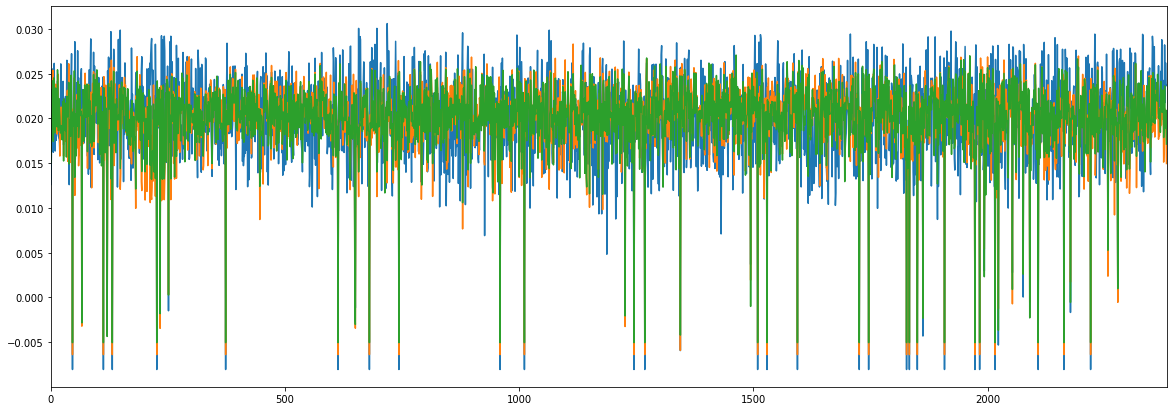

In [103]:
plt.figure(2, figsize = (20,7))

# # Normalize
# for i in range (0, len(input_list)):
#   x = similarity_scores_for_all[i]
#   max_val = max(similarity_scores_for_all[i])
#   min_val = min(similarity_scores_for_all[i])
#   similarity_scores_for_all[i] = [(float(k))]
norm=[]
sim_score_norm=[]

for i in range (0, len(input_list)):
  norm.append(np.linalg.norm(similarity_scores_for_all[i]))
  sim_score_norm.append(similarity_scores_for_all[i]/norm[i])

plt.plot(similarity_scores_for_all[0])
plt.plot(similarity_scores_for_all[1])
plt.plot(similarity_scores_for_all[2])
# plt.plot(sim_score_norm[0])
# plt.plot(sim_score_norm[1])
# plt.plot(sim_score_norm[2])
plt.xlim([0,2383])
plt.show()


In [90]:
similarity_score_avg = np.zeros([len(data)])[:,None]

similarity_final_score = np.mean(similarity_scores_for_all, axis = 0)


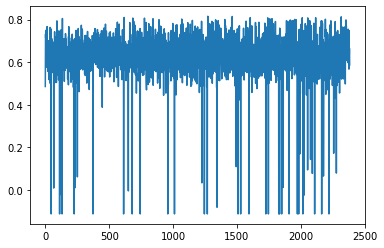

In [88]:
plt.figure()
plt.plot(avg_array)

In [77]:
max(similarity_scores_for_all[1])

0.8244300805605375

In [91]:
story_score = np.zeros([len(data)])[:,None]

story_score = similarity_final_score
story_score.shape


# normalize할지 분포 보기

(2383,)

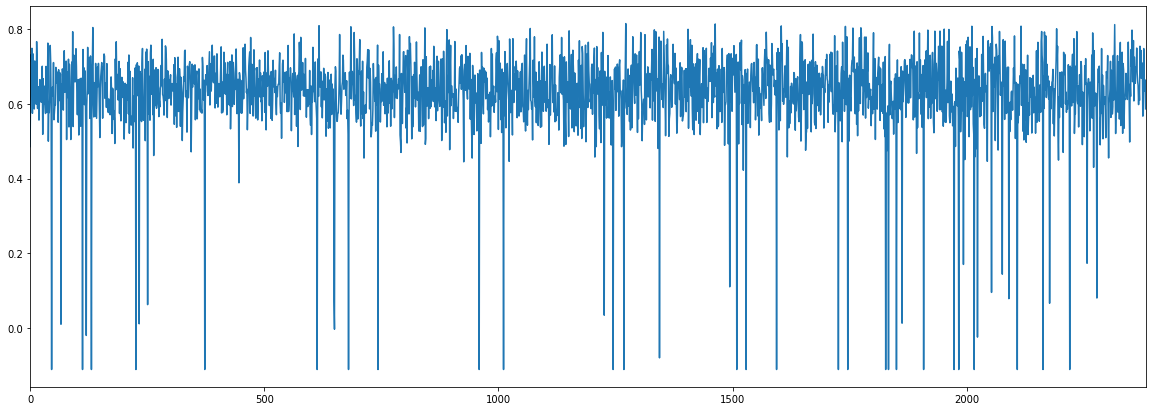

In [92]:
plt.figure(2, figsize = (20,7))
plt.plot(story_score)
plt.xlim([0,2383])
plt.show()

In [93]:
print(story_score.max())
print(story_score.min())

0.8152883059307993
-0.11153296625767


## **결과점수 (recommend_score) 계산**

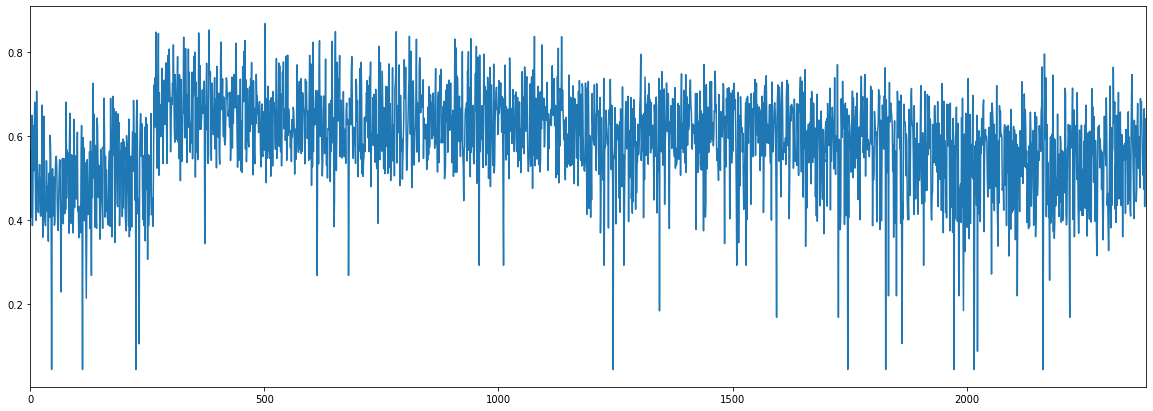

========= item based 추천 결과 =======
0.8689352032673738    미드나잇 체이서
0.8536405086770291    용왕님의 셰프가 되었습니다
0.8497807726058122    신과함께


In [106]:
# weight setting
w1 = 0.2
w2 = 0.3
w3 = 0.5

recommend_score = rating_score * w1 + genre_score * w2 + story_score * w3

# plotting
plt.figure(2, figsize = (20,7))
plt.plot(recommend_score)
plt.xlim([0,2383])
plt.show()

top1_idx = recommend_score.argsort()[-1]
print("========= item based 추천 결과 =======")
print(recommend_score[recommend_score.argsort()[-1]],"  ", title[recommend_score.argsort()[-1]])
print(recommend_score[recommend_score.argsort()[-2]],"  ", title[recommend_score.argsort()[-2]])
print(recommend_score[recommend_score.argsort()[-3]],"  ", title[recommend_score.argsort()[-3]])

#recommend_score = recommend_score[:,None]


In [109]:
recommend_score = recommend_score[:,None]

sns.heatmap(recommend_score.T, cmap='viridis')
plt.show()


ValueError: ignored